In [38]:
import requests
from dotenv import load_dotenv
import yfinance as yf
#import alpaca_trade_api as tradeapi
import plotly.express as px
import pandas as pd
import numpy as np
import panel as pn
# from panel.interact import interact
import matplotlib.pyplot as plt
from pathlib import Path
import pylab as plt
import plotly.graph_objects as go
%matplotlib inline
%matplotlib notebook

pn.extension('plotly') 


import hvplot.pandas
from pandas import DataFrame

import seaborn as sns
import scipy.optimize as sco


In [23]:
load_dotenv()

True

In [24]:
ticker_list = ['AGG','VTI','GLD','BTC-USD']

In [25]:
def tickerListGrab(ticker_list, period="5y"):
    df_price = pd.DataFrame()
    df_return = pd.DataFrame()
   
    for ticker in ticker_list:
        out = [0]
        symbol = yf.Ticker(ticker)
        symbol_list = symbol.history(period=period)
        symbol_list = symbol_list.drop(["Dividends","Stock Splits"],axis = 1)
        symbol_list = symbol_list.dropna()
        symbol_list = symbol_list.sort_index(ascending=True)
        for i in range(len(symbol_list)-1):
            out.append((symbol_list['Close'][i+1]-symbol_list['Close'][i])/symbol_list['Close'][i])
        symbol_list['Return'] = out
        df_price = pd.concat([df_price,symbol_list['Close']],axis=1)
        df_return = pd.concat([df_return,symbol_list['Return']],axis=1)
        df_price = df_price.rename(columns={'Close':ticker+'_Close'})
        df_return = df_return.rename(columns={'Return':ticker+'_Return'})
 
    df_price = df_price.dropna()
    df_return = df_return.dropna()
    return df_price,df_return

In [26]:
df_price,df_return = tickerListGrab(ticker_list)
df_price

,AGG_Close,VTI_Close,GLD_Close,BTC-USD_Close
2017-01-17,96.531479,106.972778,115.849998,907.937988
2017-01-18,96.114464,107.220245,114.870003,886.617981
2017-01-19,95.866005,106.798607,114.769997,899.072998
2017-01-20,95.901474,107.165268,115.050003,895.026001
2017-01-23,96.167664,106.881088,115.790001,921.012024
...,...,...,...,...
2022-01-07,112.489998,236.110001,167.750000,41557.902344
2022-01-10,112.389999,235.699997,168.259995,41821.261719
2022-01-11,112.599998,238.050003,170.289993,42735.855469
2022-01-12,112.599998,238.419998,170.740005,43949.101562


In [28]:
#TAYLOR - We want to also see how these have performed over time via %.
log_returns = np.log(df_price/df_price.shift(1))
log_returns.mean() * 252
#We use log returns on individuals stocks. https://www.investopedia.com/articles/investing/102014/lognormal-and-normal-distribution.asp. log_returns = np.log(pf_data/pf_data.shift(1))
cov_mat = log_returns.cov() * 252

In [29]:
#heres - https://www.codingfinance.com/post/2018-05-31-portfolio-opt-in-python/
# and where https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/

num_port = 1000
# Creating an empty array to store portfolio weights
all_wts = np.zeros((num_port, 4))
# Creating an empty array to store portfolio returns
port_returns = np.zeros((num_port))
# Creating an empty array to store portfolio risks
port_risk = np.zeros((num_port))
# Creating an empty array to store portfolio sharpe ratio
sharpe_ratio = np.zeros((num_port))

for i in range(num_port):
    wts = np.random.uniform(size = 4)
    wts = wts/np.sum(wts)
  
  # saving weights in the array
    all_wts[i,:] = wts
  
  # Portfolio Returns
    port_ret = np.sum(log_returns.mean() * wts)
    port_ret = (port_ret + 1) ** 252 - 1
  
  # Saving Portfolio returns
    port_returns[i] = port_ret
    
  # Portfolio Risk
    port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
    port_risk[i] = port_sd
  
  # Portfolio Sharpe Ratio, Assuming 0% Risk Free Rate
    sr = port_ret / port_sd
    sharpe_ratio[i] = sr
    

In [30]:
#METHOD 2 - Let's build the table and locate it that way
port_data = {'Returns': port_returns, 'Volatility': port_risk, 'Sharpe': sharpe_ratio}
for counter, symbol in enumerate(df_price.columns.tolist()):
    port_data[symbol+'weight']=[w[counter] for w in all_wts]

In [31]:
portfolios_v1 = pd.DataFrame(port_data)
portfolios_v1

,Returns,Volatility,Sharpe,AGG_Closeweight,VTI_Closeweight,GLD_Closeweight,BTC-USD_Closeweight
0,0.510166,0.381123,1.338588,0.096365,0.184708,0.250658,0.468269
1,0.391754,0.304093,1.288271,0.183363,0.061593,0.384539,0.370505
2,0.379801,0.300140,1.265411,0.427119,0.082406,0.118742,0.371733
3,0.127768,0.119276,1.071194,0.009623,0.467902,0.513840,0.008635
4,0.106838,0.078107,1.367851,0.658051,0.143540,0.136328,0.062081
...,...,...,...,...,...,...,...
995,0.192192,0.143872,1.335848,0.333915,0.493638,0.065328,0.107119
996,0.175785,0.128753,1.365295,0.322328,0.198466,0.358563,0.120643
997,0.206623,0.151599,1.362962,0.002702,0.450182,0.439466,0.107651
998,0.118291,0.114044,1.037238,0.062887,0.461438,0.474937,0.000739


In [32]:
#Min volatility
min_vol_port = portfolios_v1.iloc[portfolios_v1['Volatility'].idxmin()]
min_vol_port_df = pd.DataFrame(min_vol_port)
min_vol_value = min_vol_port_df.iloc[1]
min_vol_value = min_vol_value.values.astype(float)
min_vol_return = min_vol_port_df.iloc[0]
min_vol_return = min_vol_return.values.astype(float)
#Display the lowest volatility portfolio
#min_vol_port
min_vol_value

array([0.05730685])

In [48]:
#Find the optimal portfolio with the highest Sharpe Ratio. Assume the risk free rate is 0.
rf=0.0
optimal_risky_port= portfolios_v1.iloc[((portfolios_v1['Returns']-rf)/portfolios_v1['Volatility']).idxmax()]
optimal_risky_port_df = pd.DataFrame(optimal_risky_port)
best_sharpe_value = optimal_risky_port_df.iloc[2].values
best_sharpe_volatility = optimal_risky_port_df.iloc[1].values
best_sharpe_returns  = optimal_risky_port_df.iloc[0].values
#Display the highest sharpe portfolio
optimal_risky_port

Returns                0.751270
Volatility             0.533583
Sharpe                 1.407971
AGG_Closeweight        0.007838
VTI_Closeweight        0.304883
GLD_Closeweight        0.025023
BTC-USD_Closeweight    0.662256
Name: 665, dtype: float64

In [34]:
#Double check the above table through calculations...
#Let's look at portfolios with minimum volatilty, maximum sharpe, and their distributions
names = df_price.columns
min_var = all_wts[port_risk.argmin()]
print(f"The portfolio distribution with minimum volatity of {port_risk.min()} is {min_var}")
max_sr = all_wts[sharpe_ratio.argmax()]
print(f"The portfolio distribution with Maximum Sharpe Ratio of {sharpe_ratio.max()} is {max_sr}")

The portfolio distribution with minimum volatity of 0.05730684710308111 is [0.65176614 0.09893139 0.24622364 0.00307882]
The portfolio distribution with Maximum Sharpe Ratio of 1.4079711563709127 is [0.00783793 0.30488304 0.02502283 0.6622562 ]


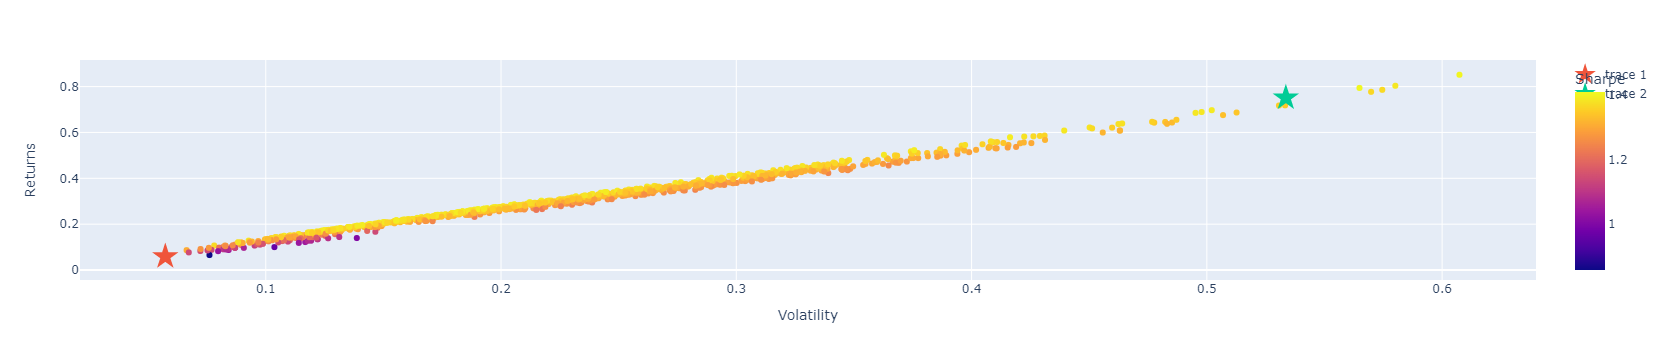

In [49]:
#Plotting Optimal Portfolio & minimum volatitility
plotted = px.scatter(portfolios_v1, x="Volatility", y="Returns", color= "Sharpe")
#Plot the lowest volatility
plotted.add_trace(go.Scatter(mode = 'markers', x=min_vol_value, y=min_vol_return, marker_symbol = 'star', marker_size = 20))
#Plot the Best Sharpe
plotted.add_trace(go.Scatter(mode = 'markers', x=best_sharpe_volatility, y=best_sharpe_returns, marker_symbol = 'star', marker_size = 20))

In [ ]:
# min_var = pd.Series(min_var, index=names)
# min_var = min_var.sort_values()
# min_var

In [ ]:
# max_sr = pd.Series(max_sr, index=names)
# max_sr = max_sr.sort_values()
# max_sr